In [1]:
from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics
import pandas as pd
import numpy as np
np.random.seed(0)
from sklearn.model_selection import GridSearchCV, StratifiedKFold  # , cross_val_score
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, precision_recall_fscore_support, confusion_matrix  # , classification_report
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.metrics import average_precision_score


In [2]:
DATA_PATH = "./data/"
RED = DATA_PATH + "just_red/"

In [3]:
sn_train = pd.read_pickle(RED + 'sn_just_red.pickle')

sn_train.shape

sn_test = pd.read_pickle(RED + "msn_just_red.pickle")

sn_test.shape

allnsn_small = pd.read_pickle(RED+"nsn_just_red.pickle")

allnsn_small.shape

(94054, 32)

In [4]:
sn_train = sn_train.reset_index(level=['ID'])
sn_test=sn_test.reset_index(level=['ID'])
allnsn_small=allnsn_small.reset_index(level=['ID'])

In [5]:
allnsn_small.head()

ID   Class  ObsCount    amplitude  beyond1st  \
copy_num BANDPASS                                                   
0        r          525  non-sn        21     2.784088   0.238095   
         r         1050  non-sn         8    10.123979   0.375000   
         r         2100  non-sn        11     0.921022   0.090909   
         r         2625  non-sn        37     5.292554   0.297297   
         r         4200  non-sn        73  1312.769684   0.150685   

                   flux_percentile_ratio_mid20  flux_percentile_ratio_mid35  \
copy_num BANDPASS                                                             
0        r                            0.120778                     0.278175   
         r                            0.176012                     0.359274   
         r                            0.123105                     0.274270   
         r                            0.167055                     0.273983   
         r                            0.069020                     0.142354   

                   flux_percentile_ratio_mid50  flux_percentile_ratio_mid65  \
copy_num BANDPASS                                                             
0        r                            0.349190                     0.461666   
         r                            0.530753                     0.689270   
         r                            0.360918                     0.454953   
         r                            0.407491                     0.666405   
         r                            0.289122                     0.392484   

                   flux_percentile_ratio_mid80    ...          poly3_t3  \
copy_num BANDPASS                                 ...                     
0        r                            0.679692    ...     -5.151591e-08   
         r                            0.869265    ...      1.058821e-07   
         r                            0.628280    ...      3.013026e-10   
         r                            0.837069    ...               NaN   
         r                            0.560951    ...      1.175779e-06   

                   poly4_t1  poly4_t2      poly4_t3      poly4_t4      skew  \
copy_num BANDPASS                                                             
0        r         0.007495 -0.000007 -5.200587e-08  2.312864e-11 -0.475762   
         r         0.085400  0.000922 -1.577389e-06 -1.078177e-08 -0.917570   
         r         0.000625 -0.000012 -9.714068e-09  5.338358e-11  1.846738   
         r              NaN       NaN           NaN           NaN -0.196945   
         r        -0.269725  0.004523  1.598822e-06 -2.333941e-08 -3.108114   

                   small_kurtosis         std  stetson_j  stetson_k  
copy_num BANDPASS                                                    
0        r              -3.508772    1.307395   0.201211   0.787575  
         r              -4.900000    7.190315   0.901598   0.868688  
         r              -4.166667    0.528050   0.205339   0.789698  
         r              -3.267227    2.752136   0.479809   0.811090  
         r              -3.129175  361.948228  10.149231   0.450519  

[5 rows x 33 columns]

In [6]:
nsns_test = allnsn_small.sample(300)

nsns_train = allnsn_small[~allnsn_small.ID.isin(nsns_test.ID)].sample(5000)

sn_test.shape

(125, 33)

In [7]:

all_train = pd.concat([sn_train,nsns_train])

all_test = pd.concat([sn_test,nsns_test])

all_test.shape

(425, 33)

In [8]:
all_test.head()

ID Class  ObsCount   amplitude  beyond1st  \
copy_num BANDPASS                                                      
0        r          MSN_10502    sn         6   58.077763   0.166667   
         r          MSN_87679    sn        13   36.688019   0.230769   
         r          MSN_62488    sn        32   21.441566   0.187500   
         r         MSN_109221    sn         6  207.314850   0.333333   
         r          MSN_78247    sn        14   33.685116   0.285714   

                   flux_percentile_ratio_mid20  flux_percentile_ratio_mid35  \
copy_num BANDPASS                                                             
0        r                            0.140234                     0.238541   
         r                            0.096094                     0.215320   
         r                            0.178923                     0.257974   
         r                            0.200743                     0.366527   
         r                            0.190321                     0.415214   

                   flux_percentile_ratio_mid50  flux_percentile_ratio_mid65  \
copy_num BANDPASS                                                             
0        r                            0.336849                     0.501989   
         r                            0.546975                     0.788768   
         r                            0.345656                     0.589671   
         r                            0.532311                     0.702362   
         r                            0.578104                     0.743562   

                   flux_percentile_ratio_mid80    ...          poly3_t3  \
copy_num BANDPASS                                 ...                     
0        r                            0.800796    ...      9.016674e-05   
         r                            0.894620    ...     -4.634778e-05   
         r                            0.730178    ...      5.367957e-08   
         r                            0.880945    ...     -2.465233e-05   
         r                            0.913003    ...     -6.484506e-05   

                   poly4_t1  poly4_t2      poly4_t3      poly4_t4      skew  \
copy_num BANDPASS                                                             
0        r         5.572242 -0.065871 -2.775492e-04  1.779698e-06 -1.468838   
         r         0.061908  0.003250 -1.957856e-04  6.240682e-07  1.098183   
         r        -0.015940  0.000180 -3.643523e-08 -8.538638e-10  1.429591   
         r         3.747489  0.039929 -3.768337e-07 -2.979538e-07  0.795263   
         r         1.397510 -0.034148  7.467707e-05  4.727784e-07  0.205848   

                   small_kurtosis         std   stetson_j  stetson_k  
copy_num BANDPASS                                                     
0        r              -6.250000   41.410893 -209.631983   0.802092  
         r              -3.927273   26.148638  373.477711   0.844361  
         r              -3.313793    9.458617  -15.929172   0.682591  
         r              -6.250000  159.138179  281.030291   0.875394  
         r              -3.840909   22.864441  208.435034   0.722529  

[5 rows x 33 columns]

In [9]:
all_train.head()

ID Class  ObsCount  amplitude  beyond1st  \
copy_num BANDPASS                                               
0        r         SN_0    sn        19  54.698450   0.210526   
         r         SN_1    sn         6  12.030315   0.166667   
         r         SN_2    sn         7  23.874100   0.285714   
         r         SN_3    sn        12  35.911500   0.166667   
         r         SN_4    sn         8  25.544500   0.250000   

                   flux_percentile_ratio_mid20  flux_percentile_ratio_mid35  \
copy_num BANDPASS                                                             
0        r                            0.104800                     0.211943   
         r                            0.302202                     0.418417   
         r                            0.348237                     0.593532   
         r                            0.065509                     0.166607   
         r                            0.595424                     0.708641   

                   flux_percentile_ratio_mid50  flux_percentile_ratio_mid65  \
copy_num BANDPASS                                                             
0        r                            0.415700                     0.769930   
         r                            0.534631                     0.676756   
         r                            0.711759                     0.829987   
         r                            0.347385                     0.623769   
         r                            0.795780                     0.854233   

                   flux_percentile_ratio_mid80    ...      poly3_t3  poly4_t1  \
copy_num BANDPASS                                 ...                           
0        r                            0.866114    ...      0.000701 -1.537085   
         r                            0.870702    ...     -0.000427 -0.175987   
         r                            0.932767    ...     -0.004393  2.365524   
         r                            0.767338    ...      0.000814 -1.563106   
         r                            0.934999    ...      0.002213 -1.861463   

                   poly4_t2  poly4_t3  poly4_t4      skew  small_kurtosis  \
copy_num BANDPASS                                                           
0        r         0.063386  0.000220 -0.000020  1.192812       -3.573529   
         r        -0.008682 -0.000651  0.000020  1.229430       -6.250000   
         r        -0.201343 -0.004620  0.000271 -0.292981       -5.400000   
         r         0.034961  0.000527 -0.000018  1.663708       -4.033333   
         r        -0.117295  0.002104  0.000228 -0.233179       -4.900000   

                         std  stetson_j  stetson_k  
copy_num BANDPASS                                   
0        r         39.741098  15.403565   0.930185  
         r          9.737427   1.204911   0.880954  
         r         19.276526   3.163353   0.916520  
         r         22.546001   5.325382   0.831058  
         r         21.706998   9.034719   0.957043  

[5 rows x 33 columns]

In [10]:
all_train.isna().sum()

ID                                      0
Class                                   0
ObsCount                                0
amplitude                               0
beyond1st                               0
flux_percentile_ratio_mid20             0
flux_percentile_ratio_mid35             0
flux_percentile_ratio_mid50             0
flux_percentile_ratio_mid65             0
flux_percentile_ratio_mid80             0
kurtosis                                0
max_slope                               2
median_absolute_deviation               0
median_buffer_range_percentage          0
pair_slope_trend                        0
pair_slope_trend_last_30                0
percent_amplitude                       0
percent_difference_flux_percentile      0
poly1_t1                              110
poly2_t1                              110
poly2_t2                              110
poly3_t1                              110
poly3_t2                              110
poly3_t3                          

In [11]:
all_df = pd.concat([all_train,all_test])

In [27]:
all_df['fact_class'] = pd.factorize(all_df['Class'])[0]
all_df['fact_class'] = (all_df['fact_class'] + 1)%2

In [28]:
all_df = all_df.fillna(0)

In [30]:
all_df.tail()


ID   Class  ObsCount  amplitude  beyond1st  \
copy_num BANDPASS                                                   
0        r          20240  non-sn        68   2.556258   0.250000   
         r          61964  non-sn        13   1.290693   0.230769   
         r         181475  non-sn        21   5.812268   0.238095   
         r         208502  non-sn        38  63.693846   0.210526   
         r         258093  non-sn         6   4.579278   0.500000   

                   flux_percentile_ratio_mid20  flux_percentile_ratio_mid35  \
copy_num BANDPASS                                                             
0        r                            0.162583                     0.245238   
         r                            0.141691                     0.255854   
         r                            0.092633                     0.217939   
         r                            0.127518                     0.236147   
         r                            0.066713                     0.309550   

                   flux_percentile_ratio_mid50  flux_percentile_ratio_mid65  \
copy_num BANDPASS                                                             
0        r                            0.382648                     0.555084   
         r                            0.286383                     0.524116   
         r                            0.307820                     0.449970   
         r                            0.370054                     0.419828   
         r                            0.552387                     0.761899   

                   flux_percentile_ratio_mid80     ...      poly4_t1  \
copy_num BANDPASS                                  ...                 
0        r                            0.788960     ...      0.000534   
         r                            0.856405     ...     -0.002577   
         r                            0.571817     ...     -0.010932   
         r                            0.651809     ...      0.090167   
         r                            0.904759     ...     -0.358047   

                   poly4_t2      poly4_t3      poly4_t4      skew  \
copy_num BANDPASS                                                   
0        r         0.000005 -7.127014e-09 -3.772394e-11  0.159163   
         r         0.000051  2.108024e-08 -3.491630e-10 -1.159966   
         r         0.000013  9.362850e-08 -2.660781e-10  0.226644   
         r        -0.000016 -2.160937e-06 -1.799664e-09  1.166120   
         r         0.005420 -1.180296e-05 -8.357643e-08  0.176803   

                   small_kurtosis        std  stetson_j  stetson_k  fact_class  
copy_num BANDPASS                                                               
0        r              -3.139161   0.979500  -0.119073   0.785157           0  
         r              -3.927273   0.811621   0.550264   0.764891           0  
         r              -3.508772   3.020842  -0.064235   0.764800           0  
         r              -3.259524  24.510690  -3.128376   0.739821           0  
         r              -6.250000   3.512571  -2.544183   0.822271           0  

[5 rows x 34 columns]

In [31]:
all_df.isna().sum()

ID                                    0
Class                                 0
ObsCount                              0
amplitude                             0
beyond1st                             0
flux_percentile_ratio_mid20           0
flux_percentile_ratio_mid35           0
flux_percentile_ratio_mid50           0
flux_percentile_ratio_mid65           0
flux_percentile_ratio_mid80           0
kurtosis                              0
max_slope                             0
median_absolute_deviation             0
median_buffer_range_percentage        0
pair_slope_trend                      0
pair_slope_trend_last_30              0
percent_amplitude                     0
percent_difference_flux_percentile    0
poly1_t1                              0
poly2_t1                              0
poly2_t2                              0
poly3_t1                              0
poly3_t2                              0
poly3_t3                              0
poly4_t1                              0


In [32]:
all_test = all_df.tail(len(all_test))

In [33]:
all_train = all_df.head(len(all_train))

In [34]:
print(all_train.shape)
print(all_test.shape)

(9862, 34)
(425, 34)


In [45]:
all_train = all_train.sample(frac=1)
all_test = all_test.sample(frac=1)

In [46]:
features = all_train.columns[2:-1]

y_train = np.array(all_train['fact_class'])
y_train

array([1, 0, 1, ..., 1, 0, 1])

In [47]:
clf = RandomForestClassifier(n_estimators=50,random_state=0, class_weight='balanced')

In [48]:

clf.fit(all_train[features], y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=50, n_jobs=1, oob_score=False, random_state=0,
            verbose=0, warm_start=False)

In [49]:
all_test = all_test.fillna(0)

In [50]:
preds = clf.predict(all_test[features])

In [51]:
y_test = all_test['fact_class']

In [52]:
pd.crosstab(preds, y_test, rownames=['Predicted '], colnames=['Actual '])

Actual,0,1
Predicted,,
0,299,74
1,1,51


In [53]:
clf.score(all_test[features],y_test)


0.8235294117647058

Text(0,0.5,'precision')

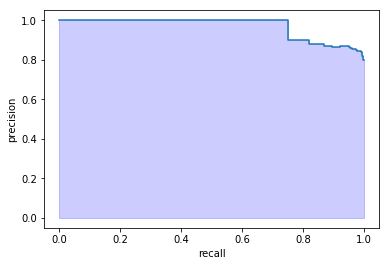

In [54]:
# plt.style.use(['dark_background'])
preds1 = clf.predict_proba(all_test[features])
precision, recall, _ = precision_recall_curve(y_test, preds1[:,0],pos_label=0)

plt.step(recall,precision)
plt.fill_between(recall, precision,step='pre', alpha=0.2,
                 color='b')
plt.xlabel('recall')
plt.ylabel('precision')

In [58]:
from scipy import integrate
integrate.trapz(precision[::-1],recall[::-1])

0.930240147849234

In [59]:
f1_score(np.array(preds),np.array(y_test))

0.576271186440678